In [1]:
import sys, os

import numpy as np

from scipy import optimize


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
current_palette = sns.color_palette()

Here, I model the fund as a learning agent, which is able to adjust its demand function over time

In [2]:
from thurner_model import NoiseTrader, find_equilibrium 
import plotting

In [3]:
V = 1
N = 1000

In [4]:
class Fund:
    """
    The funds in our model are value investors who base 
    their demand D_h_t on a mispricing signal m_t = V - p_t.
    The perceived fundamental value V is held constant and 
    is the same for the noise traders and for all funds
    
    Funds differ only according to an aggression parameter 
    beta_h that represents how sensitive their response is 
    to the signal m.
    """
    
    initial_wealth = 2
    lambda_max = 20
    
    def __init__(self, beta):
        self.beta = beta
        self.cash = self.initial_wealth
        self.shares = 0 
        self.activation_delay = 0
        
    def check_and_make_bankrupt(self, p_t):
        """
        Checks whether a fund goes bankrupt
        If so, reset its shares and wealth, set an
        activation_delay, after which the fund reinitiates
        (if the fund is already bankrupt,
        the activation_delay is decreased)
        """
        # can only go bankrupt if active
        if self.is_active():
            # if wealth drops below 10% of initial_wealth
            if self.get_wealth(p_t) <= self.initial_wealth*0.1:
                # "make" fund bankrupt
                self.shares = 0
                self.cash = self.initial_wealth
                self.activation_delay = 100
                return True
            
            # if fund in not bankrupt, return False
            else: return False

    def get_wealth(self, p_t):
        """
        TODO
        """
        return max(0, self.shares * p_t + self.cash)

    #!!! for learning behaviour see LeBaron2012 !!!

    def get_demand(self, p_t):
        """
        Oh look, a docstring
        """ 
        # the mispricing signal m_t is the difference
        # between the fundamental value V and the price p_t
        m_t = V - p_t
        m_critical = self.lambda_max / self.beta        
        
        # if the mispricing signal m_t is positive and 
        # m_critical is not reached, yet
        if 0 < m_t and m_t < m_critical:
            return self.beta * m_t * self.get_wealth(p_t) / p_t 
        # if m_critical is reached, fund leverages 
        # to the maximum 
        elif m_t >= m_critical:
            return self.lambda_max * self.get_wealth(p_t) / p_t

        # if m_t < 0, ie the mispricing signal, is negative,
        # demand is zero
        else:
            return 0

    def is_active(self):
        return self.activation_delay == 0

    def process_inflows(self, oldprice, newprice):
        pass #used later

    def update_fund_holdings(self, p_t):
        wealth = self.get_wealth(p_t)
        self.shares = self.get_demand(p_t)
        self.cash = wealth - self.shares * p_t

In [5]:
# 1. Initialize Agents

def simulate(iterations):
    # the perceived fundamental value is V
    V = 1
    # the total supply of the asset is N
    N = 1000

    # 1. Initialize agents and parameters

    # Initialize our noise trader 
    roh_nt = 0.99
    sigma_nt = 0.035
    noise_trader = NoiseTrader(roh_nt, sigma_nt, V, N)
    
    nt_spending = [N*V]
    
    # Initialize our funds 
    funds = []
    number_of_funds = 10
    
    for h in range(number_of_funds):
        # betas range from 5 to 50 (5,10,15,...,50)
        beta_h = (h+1)*5
        
        # TODO
        funds.append(Fund(beta_h))
        
    
    # 2. SIMULATION
    
    initial_price = 1
    prices = [initial_price]
    total_fund_wealth = []
    
    for i in range(iterations):
    
        p_tm1 = prices[-1]
        # Noise trader spending 
        xi_tm1 = nt_spending[-1]
        xi_t = noise_trader.cash_spending(xi_tm1)
        nt_spending.append(xi_t)
    
        p_t = find_equilibrium(xi_t, funds)
    
        # Fund demand
        funds_wealth_t = [] 
    
        for fund in funds:
            
            if fund.is_active():
                fund.update_fund_holdings(p_t)
                fund.check_and_make_bankrupt(p_t)
                fund.process_inflows(p_tm1, p_t)
            
            else:
                fund.activation_delay -= 1
            
            wealth_fund_t = fund.get_wealth(p_t)
            funds_wealth_t.append(wealth_fund_t)
   
        total_fund_wealth.append(funds_wealth_t)
    
        prices.append(p_t)
    
    prices = prices[1:]

    return {'iterations':iterations,
            'prices':prices,
            'wealth':total_fund_wealth,
            'num_funds': number_of_funds,
            'funds': funds}

In [6]:
def plot_prices(result):
    plt.figure(figsize=(16,4))
    plt.plot(result['prices'], 'b',
             label='including funds')
    plt.xlabel('Iterations')
    plt.ylabel('Price')
    plt.legend(loc='upper left')

    plt.plot()
    #plt.savefig("{}simulated_prices_{}_funds.png".format(outpath, result['num_funds']))

In [7]:
# Run the simulation
result = simulate(iterations=10000)

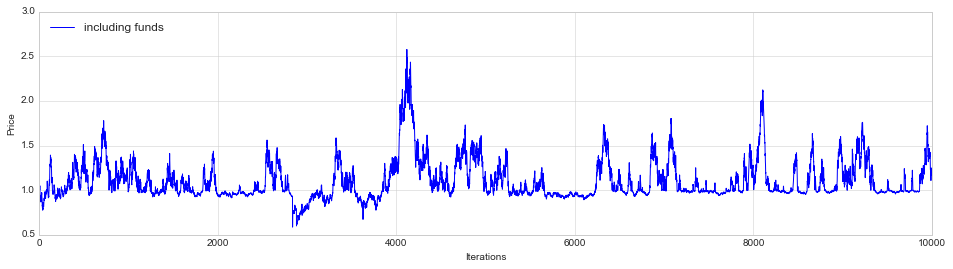

In [8]:
# Plot prices
plot_prices(result)

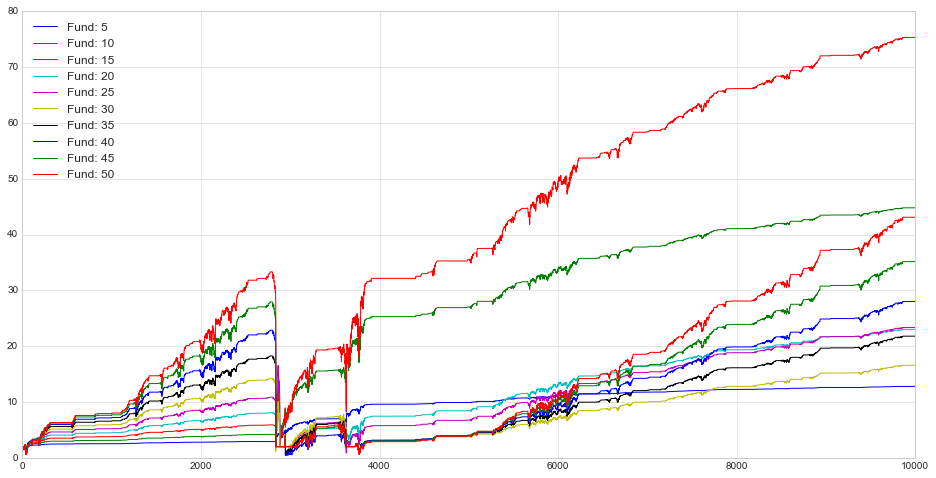

In [9]:
# Plot the wealth of all funds
plt.figure(figsize=(16,8))
plt.plot(result['wealth']);
#plt.savefig("{}simulated_wealth_{}_funds.png".format(outpath, result['num_funds']))
plt.legend(["Fund: {}".format(fund.beta) for fund in result['funds']], loc='best');

In [10]:
class LearningFund(Fund):
    """
    Description
    """
    lambda_max = 20
    beta = 10
    
    def __init__(self):
        pass
    
    def get_wealth(self, shares, p_t, cash):
        return max(0, shares * p_t + cash)
    
    def get_demand(self, state):
        
        p_t = state[0]
        wealth = state[1]
        cash = state[2]
        shares = state[3]
        
        m_t = V - state[0]
        
        if m_t < 0:
            return 0
        
        leverage = min(self.beta * m_t, self.lambda_max)
        
        return leverage * self.get_wealth(shares, p_t, cash) / p_t

In [11]:
fund = LearningFund()

initial_price = 1
initial_wealth = 2
initial_cash = initial_wealth
initial_shares = 0 
initial_activation_delay = 0 

initial_state = np.array([initial_price, initial_wealth, initial_cash, initial_shares, initial_activation_delay])

In [12]:
def calculate_excess_demand(xi_t, funds, p_t):
    demand = xi_t / p_t
    for f in funds:
        demand += f.get_demand(p_t)
    return demand - N
        
def find_equilibrium(xi_t, funds):
    # The scipy solver wants an univariate function,
    # so we create a temporary demand function 
    # that only depends on p_t, with the other two
    # parameters staying constant
    
    current_excess_demand = \
        lambda  p_t : calculate_excess_demand(xi_t, funds, p_t)
    
    return scipy.optimize.brentq(current_excess_demand,
                                 minPrice,
                                 maxPrice)

In [132]:
class Env:
    """
    Docstring
    """
    
    # Define our noise trader (uses the NoiseTrader Class defined in thurner_model.py)
    roh_nt = 0.99
    sigma_nt = 0.035
    noise_trader = NoiseTrader(roh_nt, sigma_nt, V, N)
    initial_nt_spending = V*N
    
    def __init__(self):
        
        # The enviroment is in a state, which specifies five different variables
        # This state will be read by our fund and used for its decision-making about its demand
        self.state = np.zeros(5) 
        
        # the values of our variables in the initial state are described below
        self.initial_price = 1.
        self.initial_wealth = 2.
        self.initial_cash = self.initial_wealth
        self.initial_shares = 0.
        self.initial_activation_delay = 0.
        
        self.initial_state = np.array([self.initial_price,
                                      self.initial_wealth,
                                      self.initial_cash,
                                      self.initial_shares,
                                      self.initial_activation_delay])
        
        # noise trader parameters and instance, this is not observed by the fund
        # therefore it is not in the environment's state
        self.xi_t = self.initial_nt_spending
        
        
    # when resetting the environment, we set its state back to the initial state
    def reset(self):
        self.state = self.initial_state.copy()    # need a copy because of np.array
        self.xi_t = self.initial_nt_spending
   
    def step(self): #, demand
        """Finds equilibrium, and updates environment parameters""" 
        
        self.xi_t = self.noise_trader.cash_spending(self.xi_t)
        
        #p_t = find_equilibrium(xi_t, fund)
        
        #return next_state, reward, done, _

In [111]:
env = Env()
print(env.state)

env.reset()
print(env.state)

env.add_ten()
print(env.state)

env.reset()
print(env.state)

[ 0.  0.  0.  0.  0.]
[ 1.  2.  2.  0.  0.]
[ 11.  12.  12.  10.  10.]
[ 1.  2.  2.  0.  0.]


In [77]:
env = Env()
env.step(5)

5.99

In [13]:
for i_episode in range(num_episodes):
    state = initial_state
    episode = []
    # One step in the environment
        for t in itertools.count():
            demand = 

array([1, 2, 2, 0, 0])

# From Denny Britz

In [ ]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    initial_price = 1
    initial_fund_wealth = 2
    initial_cash = initial_wealth
    initial_shares = 0 
    initial_activation_delay = 0 
    
    initial_state = np.array([initial_price, initial_fund_wealth, initial_cash, initial_shares, initial_activation_delay])
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        # this is our initial state
        state = initial_state
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # env.render()
            
            # Take a step
            demand = estimator_policy.predict(state)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats